## Required packages for entire project

In [1]:
# install.packages("tidyverse")
# install.packages("magrittr")
# install.packages("purrr")
# install.packages("glue")
# install.packages("stringr")
# install.packages("xml2")
# install.packages("rvest")
# remotes::install_github("dmi3kno/polite")
# install.packages('jsonlite')

In [1]:
library(tidyverse) #Base package useful for most R aspects
library(magrittr) # better handling of pipes
library(purrr) # to work with lists and map functions
library(glue) # to paste strings
library(stringr) # to hand strings
library(polite) # polite is the "polite" version of rvest
library(xml2) # required for real_html
library(rvest) # rvest makes scraping easier
library(httr)
library(jsonlite)
library(scales) # useful for changing number formats on plots

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.0     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract


Attaching package: 'glue'

The following object is masked from 'package:dplyr':

    collapse


Attaching package: 'rvest'

The following object is masked from 'package:purrr':

    pluck

The following object is masked from 'package:readr':

    guess_encoding


Attaching package: 'jsonlite'

The following object is masked from 'package:purrr':

    flatten


Attaching package: 'scales'

The following object is masked from 'package:purrr':

  

# Combination of the 2 scrapes and API

### The Numbers website scrape

In [31]:
movie_titles_url <- "https://www.the-numbers.com/movie/budgets/all" # this is the base url from where the scraping starts

page_title <- read_html(movie_titles_url)
page_title


{html_document}
<html>
[1] <head>\n<!-- Global site tag (gtag.js) - Google Analytics --><script asyn ...
[2] <body>\n\r\n<script>\r\n  window.fbAsyncInit = function() {\r\n    FB.ini ...

In [32]:
mylist <- list() #Create a list to house all the urls 
for (page in seq(1:56)) { #loop through to get to 5001 adding it to the end of the url 
    #adde the url to the list
    mylist <- c(mylist,as.character(paste0("https://www.the-numbers.com/movie/budgets/all/" , ((page - 1)* 100) + 1)))
}
#sanity check
mylist[1]

[[1]]
[1] "https://www.the-numbers.com/movie/budgets/all/1"

In [33]:
#Gets the tables of data from thenumbers.com
#Might take a while to run
movie_titles_list <- list() #Create list to house the lists of nodes
for(i in mylist){
    page_html <- read_html(i) #read in the url and turn it into html
    table_nodes <- page_html %>% html_nodes("table") %>% html_table() # Get the table in the html and make a list row out of it
    movie_titles_list <- append(movie_titles_list,table_nodes) #Append the table nodes to the list
}
#Check that something was obtained
length(movie_titles_list)

[1] 56

In [34]:
#Setting from and setting to, it is bad practice to have magic numbers in code and can lead to mistakes
from <- 2
to <- length(movie_titles_list)
the_numbers_df<- data.frame(movie_titles_list[1]) #create the first dataframe
for (i in from:to){ #start from 2 as use has been processed already
    temp <- data.frame(movie_titles_list[i]) #create a temporary dataframe
    the_numbers_df <- rbind(the_numbers_df,temp) #Using rbind the data can be merge vertically
}

In [35]:
names(the_numbers_df)[names(the_numbers_df) == 'Var.1'] <- 'Rank' # change the variable to something useful, found how to do this from https://stackoverflow.com/questions/7531868/how-to-rename-a-single-column-in-a-data-frame second answer. 
#The following functions have used this link as a reference: https://stackoverflow.com/questions/31944103/convert-currency-with-commas-into-numeric
the_numbers_df$ProductionBudget <- as.numeric(gsub('[$,]', '', the_numbers_df$ProductionBudget))
the_numbers_df$DomesticGross <- as.numeric(gsub('[$,]', '', the_numbers_df$DomesticGross))
the_numbers_df$WorldwideGross <- as.numeric(gsub('[$,]', '', the_numbers_df$WorldwideGross))
the_numbers_df <- na_if(the_numbers_df, 0)

In [36]:
saveRDS(the_numbers_df, "the_numbers_df.Rda")

In [37]:
the_numbers_df <- readRDS("the_numbers_df.Rda") #this loads the dataframe from record granted it overrides the current the_numbers_df but this makes it fool proof if dont run scrape
head(the_numbers_df) #checks the data has been saved correctly loads from rda correctly 

Rank,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,"Dec 17, 2009",Avatar,425000000,760507625,2789705275
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
3,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2795473000
4,"Apr 22, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
5,"Dec 13, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
6,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220


### RottenTomatos Website scrape

In [38]:
years <- seq(1950, 2019, 1) #first number = first year for scrape, second number = last year for scraping
# change 2018 and 2018 to 1950 and 2019 for full data scrape. 
# !!May take around 1 hour to scrape due to having to access each movie's individual web page to retrieve its data!! 

In [39]:
# function to grab each movie link for provided years
data <- function(years){
    movie_links <- NULL
    movie_links <- list()
    for(year in years){
        url_titles <- glue("https://www.rottentomatoes.com/top/bestofrt/?year={year}")
        base_page <- read_html(url_titles)

        movie_links <- append(movie_links, list(base_page %>%
            html_nodes(".allow-overflow") %>%
            html_nodes(".articleLink") %>%
            html_attr("href")
            ))

            }
    return(movie_links)
    }

In [40]:
# Retrieve movie links for the provided years
movie_links <- data(years)
# Sanity check for first movie year
movie_links[[1]]

[1] "/m/1000626-all_about_eve" "/m/sunset_boulevard"     
[3] "/m/in_a_lonely_place"

In [41]:
# Function that retrieves wanted info from a single year
get_info <- function(link){
    
    #Retrieve critic and audience rating
    movie_base_page <- glue("https://www.rottentomatoes.com{link}")
    web_data <- movie_base_page %>%
        read_html()
    movie_reviews <- web_data %>%
        html_nodes(".js-scoreboard-container") %>%
        html_nodes(".mop-ratings-wrap__percentage") %>%
        html_text() %>% 
        trimws() 
    #Retrieves the movie title
    movie_title <- web_data %>%
        html_nodes(".mop-ratings-wrap__title--top") %>%
        html_text()
    
    #grab supplementary data
    movie_info_labels <- web_data %>%
        html_nodes('.content-meta.info') %>%
        html_nodes(".meta-row.clearfix")%>%
        html_nodes('.meta-label')%>%
        html_text() %>%
        trimws()
    movie_info_data <- web_data %>%
        html_nodes('.content-meta.info') %>%
        html_nodes(".meta-row.clearfix")%>%
        html_nodes('.meta-value')%>%
        html_text() %>%
        trimws() 
    
    #formats supplementary data into key-value pairs for processing
    movie_info <- tibble(movie_info_labels, movie_info_data)
    movie_info <- spread(movie_info, 
                        key = movie_info_labels,
                        value = movie_info_data)
    

    
    #Retrieves value if the value is there otherwise sets value to NA
    if ("Rating:" %in% colnames(movie_info)){
        rating <- movie_info$"Rating:"
    } else {
        rating <- NA
    }
    if ("Runtime:" %in% colnames(movie_info)){
        runtime <- movie_info$"Runtime:"
        runtime <- gsub("[^0-9\\.]", "", runtime) %>%
                    as.numeric()
    } else {
        runtime <- NA
    }
    if ("Studio:" %in% colnames(movie_info)){
        studio <- movie_info$"Studio:"
    } else {
        studio <- NA
    }
    
    if ("Genre:" %in% colnames(movie_info)){
        genre <- movie_info$"Genre:" %>% 
                str_replace_all(fixed(" "), "") %>% 
                str_replace_all(fixed("\n"), "") %>%
                strsplit(",")
    } else {
        genre <- NA
    }
  
    if ("Box Office:" %in% colnames(movie_info)){
        box_office <- movie_info$"Box Office:" 
        box_office <- gsub("[^0-9\\.]", "", box_office) %>%
        as.numeric()
        
    } else {
        box_office <- NA
        
    }
    
    # places retrieved data from a single movie into a tibble
    processed_data <- tibble("Movie Title" = movie_title, 
                  "Critic Score (%)" = readr::parse_number(movie_reviews[1]), 
                  "Audience Score (%)" = readr::parse_number(movie_reviews[2]),
                  "Movie Rating" = rating,
                  "Box Office ($)" = as.numeric(box_office), 
                  "Runtime (m)" = runtime,
                  "Genre" = genre,
                  "Studio" = studio)

    return(processed_data)
}

# Base Test 
# get_info(movie_links[[1]][[1]])


# Creates a tibble for all the movie data from rotten tomatoes
tomato_df <- tibble()
    # loops through each year of the years provided
    for (year in movie_links){
        # loops through each movie link in each year 
      for (link in year){
          tryCatch({
               temp <- get_info(link) # places current movie data into a temp variable for combining with the rest of the data
                tomato_df <- rbind(tomato_df, temp)    #combines each movie tibble retrieved into a single tibble
          }, error = function(e){
              #pass
          }, finally = {
              #do nothing
          })
       
    }
}

In [42]:
# Saves retrieved data from Rotten tomatoes into an Rda file
saveRDS(tomato_df, "tomato_df.Rda")

# Peaks at the first few records of the Rotten Tomato scraping  
head(tomato_df)

Movie Title,Critic Score (%),Audience Score (%),Movie Rating,Box Office ($),Runtime (m),Genre,Studio
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<list>,<chr>
All About Eve,100,94,PG,NA,138,"Classics, Drama",20th Century Fox
Sunset Boulevard,98,95,G,NA,111,"Classics, Drama",Paramount Pictures
In a Lonely Place,98,89,NR,NA,93,"Classics , Drama , Mystery&Suspense, Romance",Columbia Pictures
A Streetcar Named Desire,98,90,PG,NA,122,"Classics, Drama",Warner Bros. Pictures
Rashômon,98,93,NR,NA,83,"ArtHouse&International, Classics , Drama , Mystery&Suspense",Janus Films
Strangers on a Train,98,92,PG (not rated),NA,101,Mystery&Suspense,Warner Home Video


In [43]:
# Reads a Rda file called tomato_df.Rda and saves into a variable
tomato_df <- readRDS("tomato_df.Rda")

# test that it loads the file correctly once saved to rda format
head(tomato_df) 

Movie Title,Critic Score (%),Audience Score (%),Movie Rating,Box Office ($),Runtime (m),Genre,Studio
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<list>,<chr>
All About Eve,100,94,PG,NA,138,"Classics, Drama",20th Century Fox
Sunset Boulevard,98,95,G,NA,111,"Classics, Drama",Paramount Pictures
In a Lonely Place,98,89,NR,NA,93,"Classics , Drama , Mystery&Suspense, Romance",Columbia Pictures
A Streetcar Named Desire,98,90,PG,NA,122,"Classics, Drama",Warner Bros. Pictures
Rashômon,98,93,NR,NA,83,"ArtHouse&International, Classics , Drama , Mystery&Suspense",Janus Films
Strangers on a Train,98,92,PG (not rated),NA,101,Mystery&Suspense,Warner Home Video


In [44]:
# Retrieves the movie titles from the Rotten Tomato scraping 
tomato_titles <- tomato_df[1]

# first few movie titles from the rotten tomatoes scrape
head(tomato_titles) 

Movie Title
<chr>
All About Eve
Sunset Boulevard
In a Lonely Place
A Streetcar Named Desire
Rashômon
Strangers on a Train


### Functions for turning movie titles into movie data via API

In [45]:
get_api_urls <- function(movie_title_df) { #this is a support function for later use 
    l <- nrow(movie_title_df) 
    api_urls <- vector("list", 1) #initialising an empty list to add the urls too.
    j <- 1

    for (title in movie_title_df) { 
        api_urls[[j]] <- title %>% 
        str_replace_all(" ", "_") %>%
        tolower() %>% 
        sprintf("http://www.omdbapi.com/?t=%s&apikey=3aa8a31e", .) #Here we are inserting the titles to search into the api urls to request
        j <- j + 1
    }
    return(api_urls)
}

In [46]:
get_api_results <- function(api_urls) { #helpter function 
    api_results <- vector("list", length(api_urls)) #Empty list to insert that movie data into.
    i <- 1
    
    for (url in api_urls[[1]]) {
        
        error_ressult = tryCatch({ #Errors can come up when an api call has returned an incorrect piece of data. Eg. when it finds a tv show with a similar name to a movie
            api_response <- fromJSON(url)
            movie_data <- data.frame(api_response)[1,]
            if (ncol(movie_data) == 26) { 
                api_results[[i]] <- movie_data
                i <- i + 1
             } 
        }, error = function(e) { #Here we can print the error if we need too
#             print(e)
        }, finally = {
        })
    }
    
    return(api_results)
}

In [47]:
get_api_data_df <- function(api_results) {
    #Here we aare combining the dataframes
    from <- 2 #Can skip the first entry
    to <- length(api_results)

    api_data_df <- data.frame(api_results[1]) #create the first dataframe
    for (i in from:to) {
        temp <- data.frame(api_results[i]) #create a temporary dataframe
        api_data_df <- rbind(api_data_df,temp) #Using rbind the data can be merge vertically
    }
    return(api_data_df)
}

In [48]:
# tomato_df <- readRDS("tomato_df.Rda")
# the_numbers_api <- readRDS("the_numbers_api.Rda")


### Running

In [49]:
tomato_urls <- get_api_urls(head(tomato_titles)) #currenly limited to head /5 results for testing purppspe 
tomato_api_results <- get_api_results(tomato_urls)
tomato_api <- get_api_data_df(tomato_api_results)
saveRDS(tomato_api, "tomato_api.Rda")
head(tomato_api,2)

#this gets the api results using the names from rotten tomatos

Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
All About Eve,1950,Passed,27 Oct 1950,138 min,Drama,Joseph L. Mankiewicz,Joseph L. Mankiewicz (written for the screen by),"Bette Davis, Anne Baxter, George Sanders, Celeste Holm",An ingénue insinuates herself into the lives of an established but aging stage actress and her circle of theater friends.,...,98,8.2,"111,354",tt0042192,movie,05 Oct 1999,N/A,20th Century Fox,N/A,True
Sunset Boulevard,1991,N/A,N/A,8 min,Short,Thomas Korschil,N/A,N/A,"Sunset Boulevard is the attempt to simultaneously picture the two big, contradictory myths of U.S. America: the myth of unlimited individualism (""lonesome rider""), and the myth of the ""...",...,N/A,8.2,31,tt0158253,movie,N/A,N/A,N/A,N/A,True


In [50]:
numbers_database_titles <- the_numbers_df[3]

In [51]:
#Sends the first half of thenumbers.com movie titles into the api. This is the actual function call
#This is split because the api will only accpet about 4500 at a time
numbers_urls_1 <- get_api_urls(as_tibble(numbers_database_titles)) #limit_db is to test without fixing cap of certian amou issue limits  anything beyond 4500 seems to break
numbers_api_results_1 <- get_api_results(numbers_urls_1)
the_numbers_api <- get_api_data_df(numbers_api_results_1)
saveRDS(the_numbers_api, "the_numbers_api.Rda")

#this gets the api results using the names from the numbers 

In [52]:
#this combines the rotten tomato and the numbers files in to one big api dataset
Combination_api <- rbind(the_numbers_api, tomato_api)
saveRDS(Combination_api, "Combination_api.Rda")

In [53]:
Combination_api <- readRDS("Combination_api.Rda")

# Plotting

In [2]:
# Reads in dataframes from each Web and API Scraping we performed
Combination_api <- readRDS("Combination_api.Rda") # Combined Numbers and Rotten Tomato API scrape
the_numbers_api <- readRDS("the_numbers_api.Rda") # Numbers API Scrape
the_numbers_df <- readRDS("the_numbers_df.Rda") # Numbers Web Scrape
tomato_api <- readRDS("tomato_api.Rda") # Rotten Tomato API Scrape
tomato_df <- readRDS("tomato_df.Rda") # Rotten Tomato Web Scrape

## Plot - Average Rating of a Movie Based on the Money Earned at Box-Office

In [3]:
#Read in data retrieved from the api. For this question I will be using both the Rotten Tomatoes and The Numbers data
tomato_api <- readRDS('tomato_api.Rda')
the_numbers_api <- readRDS('the_numbers_api.Rda')

#Here we bind them together, select the useful columns and filter out duplicated values
combined_api_data <- tomato_api %>% 
    rbind(the_numbers_api)  %>%
    select(c(Title, Year, Runtime, Genre, Metascore, imdbRating, BoxOffice)) %>% 
    distinct(Title, .keep_all = TRUE)

#Display the useful columns of the dataset
combined_api_data %>% head()

Title,Year,Runtime,Genre,Metascore,imdbRating,BoxOffice
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
All About Eve,1950,138 min,Drama,98,8.2,N/A
Sunset Boulevard,1991,8 min,Short,N/A,8.2,N/A
In a Lonely Place,1950,94 min,"Drama, Film-Noir, Mystery, Romance, Thriller",N/A,8.0,N/A
A Streetcar Named Desire,1951,122 min,Drama,96,8.0,N/A
Strangers on a Train,1951,101 min,"Crime, Film-Noir, Thriller",88,8.0,N/A
An American in Paris,1951,114 min,"Drama, Musical, Romance",84,7.2,N/A


In [4]:
#Here we are wrangling our data into a graphable format
specific_api_data <- combined_api_data %>% 
    #We need to change the type of "Runtime" from a 'factor' to a number, also removing the trailing characters
    mutate(Runtime = as.numeric(gsub(" min", "", Runtime))) %>% 
    #We need to do the same conversion here, removing a leading dollar sign
    mutate(BoxOffice = as.numeric(gsub("[^0-9.-]", "", BoxOffice))) %>% 
    #Here we calculate a new column, the average rating between the IMDB and the Metascore ratings. 
    mutate(Average_rating = (as.numeric(as.character(Metascore)) + (10 * as.numeric(as.character(imdbRating)))) / 2) %>%
    #We no longer need these 2 columns
    select(-c(Metascore, imdbRating)) 

specific_api_data %>% head()

Warning message:
"NAs introduced by coercion"Warning message:
"NAs introduced by coercion"Warning message:
"NAs introduced by coercion"

Title,Year,Runtime,Genre,BoxOffice,Average_rating
<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
All About Eve,1950,138,Drama,NA,90
Sunset Boulevard,1991,8,Short,NA,NA
In a Lonely Place,1950,94,"Drama, Film-Noir, Mystery, Romance, Thriller",NA,NA
A Streetcar Named Desire,1951,122,Drama,NA,88
Strangers on a Train,1951,101,"Crime, Film-Noir, Thriller",NA,84
An American in Paris,1951,114,"Drama, Musical, Romance",NA,78


Warning message:
"Removed 3181 rows containing missing values (geom_point)."

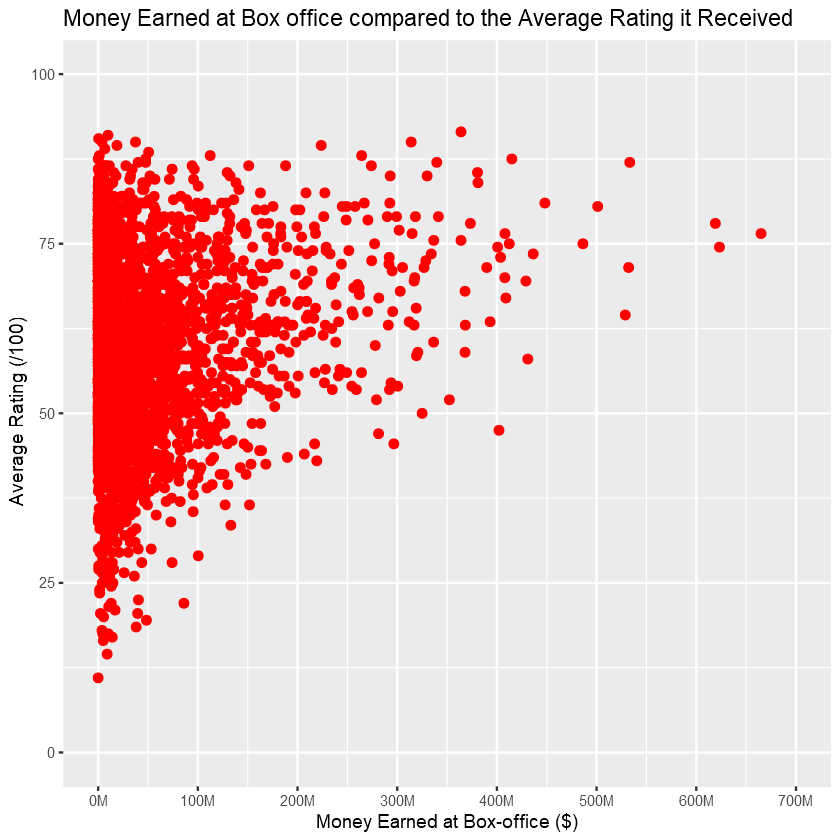

In [5]:
#In this cell we will be creating the plot

#Here we create a list of labels we will put along the X axis
xlab <- c(0, 100, 200, 300, 400, 500, 600, 700)

#Here we create the graph to try answer the question
specific_api_data %>% 
    ggplot(aes(x = BoxOffice, y = Average_rating)) +
    geom_point(colour = "red", size = 2) + #Adding a flair of colour
    ggtitle("Money Earned at Box office compared to the Average Rating it Received") + 
    ylab("Average Rating (/100)") +
    xlab("Money Earned at Box-office ($)") +
    ylim(0,100) + #Making sure the ratings go from 0 to 100
    scale_x_continuous(limits = c(0, 700000000), #Changing the x scale to be able to show all the data.
                       labels = paste0(xlab, "M"), #Getting the correct labels on the ticks 
                       breaks = 1000000 * xlab) #Getting the correct tick spacing

## Plot of Most profitable movie genre

In [14]:
# Test to convert Rotten Tomato Movie genres into a vector instead of list
test <- as.vector(tomato_df$"Genre")
head(test)

[[1]]
[1] "Classics" "Drama"   

[[2]]
[1] "Classics" "Drama"   

[[3]]
[1] "Classics"         "Drama"            "Mystery&Suspense" "Romance"         

[[4]]
[1] "Classics" "Drama"   

[[5]]
[1] "ArtHouse&International" "Classics"               "Drama"                 
[4] "Mystery&Suspense"      

[[6]]
[1] "Mystery&Suspense"

In [47]:
# Start from the very first movie record in Rotten Tomatoes Scrape
i = 1

# Get Number of Rotten Tomato records
len <- length(tomato_df$"Genre")

# Initialize a datafrom of equal length to Rotten Tomato for "Main Genre" which is the first genre listed on a movie
# This is done to avoid movies being represeted multiple times in different genres
main_genre <- data.frame(nrow = len)

# loop through each movie and grab the first listed genre for each move, place int main_genre dataframe
for (i in 1:len) {
    
    curr <- tomato_df[[7]][[i]][[1]]
    main_genre[[i]] <- curr
    

}

# loop through each record on Rotten Tomato scraping again and replace the list of genres into a single value as it s"Main Genre" 
i=1
for (i in 1:len){
    tomato_df[[7]][[i]] = main_genre[[i]]
}


In [58]:
# Check the movie genre has been changed to just its main genre 
head(tomato_df)
tomato_df$Genre <-unlist(tomato_df$Genre)

# Read in The numbers Web scraping to combine with the Rotten Tomato Web Scraping
the_numbers_df <- readRDS("the_numbers_df.Rda")
head(the_numbers_df)

Movie,Critic Score (%),Audience Score (%),Movie Rating,Box Office ($),Runtime (m),Genre,Studio
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<list>,<chr>
All About Eve,100,94,PG,NA,138,Classics,20th Century Fox
Sunset Boulevard,98,95,G,NA,111,Classics,Paramount Pictures
In a Lonely Place,98,89,NR,NA,93,Classics,Columbia Pictures
A Streetcar Named Desire,98,90,PG,NA,122,Classics,Warner Bros. Pictures
Rashômon,98,93,NR,NA,83,ArtHouse&International,Janus Films
Strangers on a Train,98,92,PG (not rated),NA,101,Mystery&Suspense,Warner Home Video


Rank,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,"Dec 17, 2009",Avatar,425000000,760507625,2789705275
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
3,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2795473000
4,"Apr 22, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
5,"Dec 13, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
6,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220


In [59]:
# Replace The Rotten Tomatoes "Movie Title" column name with "Movie" to allow join with The numbers "Movie" Column
names(tomato_df)[1] <- "Movie"

In [60]:
# Combine movie Records from The numbers and Rotten Tomatoes movie scraping through column "Movie"
# Only Combines records where A Movie is present in both dataframes
tomato_numbers_df <- inner_join(the_numbers_df,tomato_df, by ="Movie")

In [61]:
# Summarise average worldwide grossing for each movie genre, removing any record with NA values
average_worldwide_grossing <- tomato_numbers_df %>%
        group_by(Genre) %>%
        summarise(grossing = mean(WorldwideGross, na.rm=TRUE))
average_worldwide_grossing

# Summarise Total worldwide grossing for each movie genre, removing any record with NA values
total_worldwide_grossing <- tomato_numbers_df %>%
        group_by(Genre) %>%
        summarise(grossing = sum(WorldwideGross, na.rm=TRUE))
total_worldwide_grossing

Genre,grossing
<chr>,<dbl>
Action&Adventure,254517786
Animation,362548683
ArtHouse&International,19355047
Classics,84157671
Comedy,92904971
CultMovies,50057660
Documentary,25147528
Drama,85289597
Horror,93644367


Genre,grossing
<chr>,<dbl>
Action&Adventure,107151987983
Animation,18127434139
ArtHouse&International,1219367983
Classics,3702937543
Comedy,28243111206
CultMovies,50057660
Documentary,955606060
Drama,32324757413
Horror,4120352169


In [62]:
# Summarise average Budget for each movie genre, removing any record with NA values
average_budget <- tomato_numbers_df %>%
        group_by(Genre) %>%
        summarise(budget = mean(ProductionBudget, na.rm=TRUE))
average_budget

# Summarise total Budget for each movie genre, removing any record with NA values
total_budget <- tomato_numbers_df %>%
        group_by(Genre) %>%
        summarise(budget = sum(ProductionBudget, na.rm=TRUE))
total_budget

Genre,budget
<chr>,<dbl>
Action&Adventure,65048813
Animation,81943000
ArtHouse&International,9003175
Classics,18283182
Comedy,20953543
CultMovies,15000000
Documentary,7308333
Drama,22526625
Horror,17024477


In [63]:
# Joins budget and grossing tables together through column name "Genre", average with average, total with with total
averages_table <- left_join(average_budget, average_worldwide_grossing, by = "Genre")
total_tables <- left_join(total_budget, total_worldwide_grossing, by = "Genre")

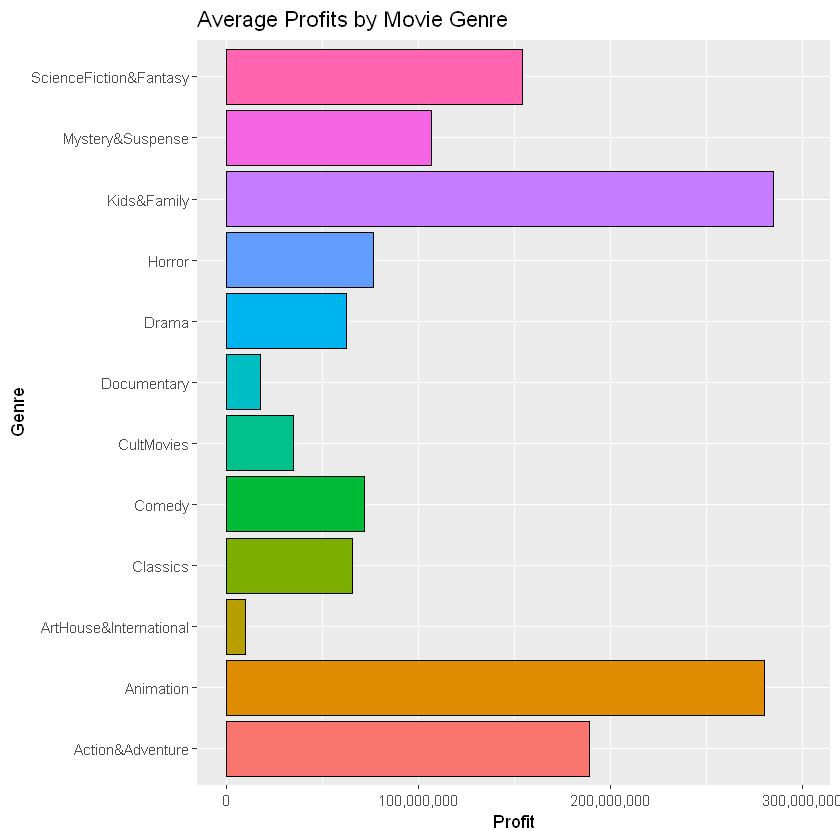

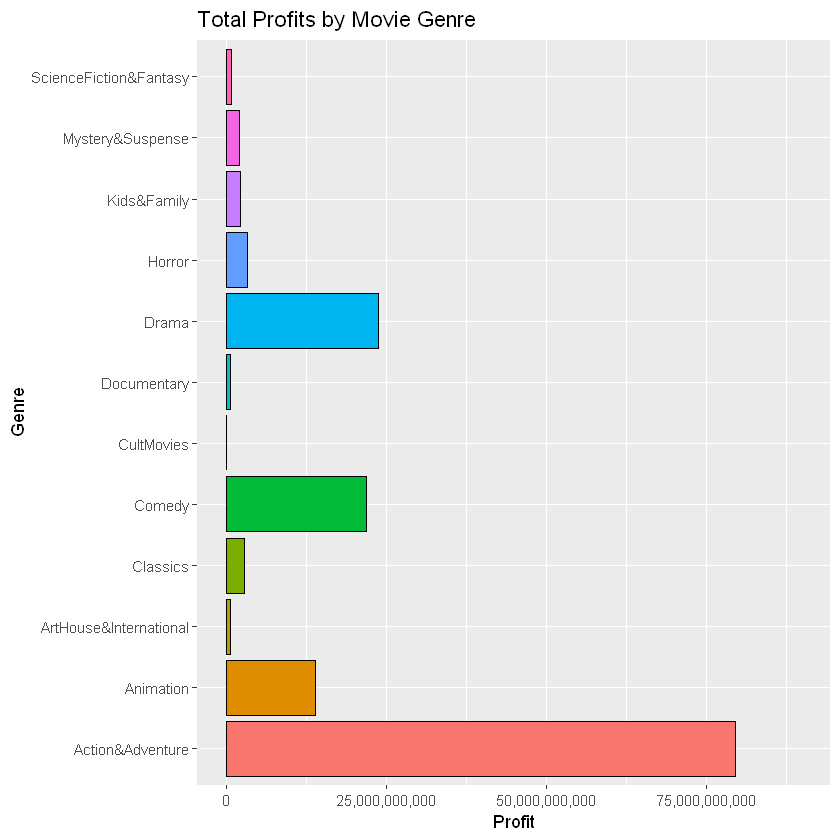

In [129]:
# Creates a new column called profit which is gained from average table grossing - budget
profit_by_genre_ave <- mutate(averages_table, Profit = grossing - budget)

# Plots a bar chart that separates by main genre and shows average profits by each genre, with profits in standard form + axis titles
ggplot(profit_by_genre_ave, aes(y = Profit, x  = Genre, fill = Genre)) + 
ggtitle("Average Profits by Movie Genre") + 
geom_bar(stat="identity", colour = "black") +
coord_flip() +
theme(legend.position = "none")+
scale_y_continuous(labels = comma,
                  limits = c(0,300000000))

# Creates a new column called profit which is gained from the total table's grossing - budget
profit_by_genre_sum<- mutate(total_tables, Profit = grossing - budget)

# Plots a bar chart that separates by main genre and shows total profits by each genre, with profits in standard form + axis titles
ggplot(profit_by_genre_sum, aes(y = Profit, x  = Genre, fill = Genre))+
ggtitle("Total Profits by Movie Genre")  + 
geom_bar(stat="identity", colour = "black") +
coord_flip()+
theme(legend.position = "none")+
scale_y_continuous(labels = comma,
                  limit = c(0,90000000000)) 

# Most profitable movie based on budget

In [32]:
#create the final numbers
final_numbers <- readRDS("Combination_api.Rda")


In [33]:
#make sure it is a dataframe
final_numbers <- data.frame(final_numbers)

In [35]:
#rename the column
names(final_numbers)[1] <- "Movie"
#check that the numbers have updated
final_numbers


Movie,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
Avatar,2009,PG-13,18 Dec 2009,162 min,"Action, Adventure, Fantasy, Sci-Fi",James Cameron,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang",A paraplegic Marine dispatched to the moon Pandora on a unique mission becomes torn between following his orders and protecting the world he feels is his home.,...,83,7.8,"1,059,860",tt0499549,movie,22 Apr 2010,"$749,700,000",20th Century Fox,N/A,True
Pirates of the Caribbean: On Stranger Tides,2011,PG-13,20 May 2011,136 min,"Action, Adventure, Fantasy",Rob Marshall,"Ted Elliott (screenplay), Terry Rossio (screenplay), Ted Elliott (screen story), Terry Rossio (screen story), Ted Elliott (characters), Terry Rossio (characters), Stuart Beattie (characters), Jay Wolpert (characters), Tim Powers (novel)","Johnny Depp, Penélope Cruz, Geoffrey Rush, Ian McShane","Jack Sparrow and Barbossa embark on a quest to find the elusive fountain of youth, only to discover that Blackbeard and his daughter are after it too.",...,45,6.6,"453,586",tt1298650,movie,18 Oct 2011,"$241,063,875",Walt Disney Pictures,N/A,True
Avengers: Endgame,2019,PG-13,26 Apr 2019,181 min,"Action, Adventure, Sci-Fi","Anthony Russo, Joe Russo","Christopher Markus (screenplay by), Stephen McFeely (screenplay by), Stan Lee (based on the Marvel comics by), Jack Kirby (based on the Marvel comics by), Jim Starlin (Thanos, Gamora & Drax created by), Jack Kirby (Groot created by)","Robert Downey Jr., Chris Evans, Mark Ruffalo, Chris Hemsworth","After the devastating events of Avengers: Infinity War (2018), the universe is in ruins. With the help of remaining allies, the Avengers assemble once more in order to reverse Thanos' actions and restore balance to the universe.",...,78,8.6,"561,813",tt4154796,movie,30 Jul 2019,N/A,Marvel Studios,N/A,True
Avengers: Age of Ultron,2015,PG-13,01 May 2015,141 min,"Action, Adventure, Sci-Fi",Joss Whedon,"Joss Whedon, Stan Lee (based on the Marvel comics by), Jack Kirby (based on the Marvel comics by), Joe Simon (character created by: Captain America), Jack Kirby (character created by: Captain America), Jim Starlin (character created by: Thanos)","Robert Downey Jr., Chris Hemsworth, Mark Ruffalo, Chris Evans","When Tony Stark and Bruce Banner try to jump-start a dormant peacekeeping program called Ultron, things go horribly wrong and it's up to Earth's mightiest heroes to stop the villainous Ultron from enacting his terrible plan.",...,66,7.3,"680,834",tt2395427,movie,02 Oct 2015,"$429,113,729",Walt Disney Pictures,N/A,True
Avengers: Infinity War,2018,PG-13,27 Apr 2018,149 min,"Action, Adventure, Sci-Fi","Anthony Russo, Joe Russo","Christopher Markus (screenplay by), Stephen McFeely (screenplay by), Stan Lee (based on the Marvel comics by), Jack Kirby (based on the Marvel comics by), Joe Simon (Captain America created by), Jack Kirby (Captain America created by), Steve Englehart (Star-Lord created by), Steve Gan (Star-Lord created by), Bill Mantlo (Rocket Raccoon created by), Keith Giffen (Rocket Raccoon created by), Jim Starlin (Thanos, Gamora and Drax created by), Stan Lee (Groot created by), Larry Lieber (Groot created by), Jack Kirby (Groot created by), Steve Englehart (Mantis created by), Don Heck (Mantis created by)","Robert Downey Jr., Chris Hemsworth, Mark Ruffalo, Chris Evans",The Avengers and their allies must be willing to sacrifice all in an attempt to defeat the powerful Thanos before his blitz of devastation and ruin puts an end to the universe.,...,68,8.5,"706,537",tt4154756,movie,14 Aug 2018,"$664,987,816",Walt Disney Pictures,http://marvel.com/movies/movie/223/avengers_infinity_war,True
Justice League,2017,PG-13,17 Nov 2017,120 min,"Action, Adventure, Fantasy, Sci-Fi",Zack Snyder,"Jerry 

In [36]:
numbers_scrape_data <- readRDS("the_numbers_df.Rda")
numbers_scrape_data

Rank,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,"Dec 17, 2009",Avatar,425000000,760507625,2789705275
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
3,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2795473000
4,"Apr 22, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
5,"Dec 13, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
6,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220
7,"Apr 25, 2018",Avengers: Infinity War,300000000,678815482,2048134200
8,"May 24, 2007",Pirates of the Caribbean: At World’s End,300000000,309420425,963420425
9,"Nov 13, 2017",Justice League,300000000,229024295,655945209


In [37]:
#join data based on Movie title
join_Scrape_and_Api_df <- left_join(numbers_scrape_data,final_numbers, by = "Movie")
#remove the unneeded columns
#check that it worked
join_Scrape_and_Api_df

Warning message:
"Column `Movie` joining character vector and factor, coercing into character vector"

Rank,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross,Year,Rated,Released,Runtime,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,"Dec 17, 2009",Avatar,425000000,760507625,2789705275,2009,PG-13,18 Dec 2009,162 min,...,83,7.8,"1,059,860",tt0499549,movie,22 Apr 2010,"$749,700,000",20th Century Fox,N/A,True
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,PG-13,20 May 2011,136 min,...,45,6.6,"453,586",tt1298650,movie,18 Oct 2011,"$241,063,875",Walt Disney Pictures,N/A,True
3,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2795473000,2019,PG-13,26 Apr 2019,181 min,...,78,8.6,"561,813",tt4154796,movie,30 Jul 2019,N/A,Marvel Studios,N/A,True
4,"Apr 22, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,PG-13,01 May 2015,141 min,...,66,7.3,"680,834",tt2395427,movie,02 Oct 2015,"$429,113,729",Walt Disney Pictures,N/A,True
5,"Dec 13, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,"Apr 25, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,PG-13,27 Apr 2018,149 min,...,68,8.5,"706,537",tt4154756,movie,14 Aug 2018,"$664,987,816",Walt Disney Pictures,http://marvel.com/movies/movie/223/avengers_infinity_war,True
8,"May 24, 2007",Pirates of the Caribbean: At World’s End,300000000,309420425,963420425,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,"Nov 13, 2017",Justice League,300000000,229024295,655945209,2017,PG-13,17 Nov 2017,120 min,...,45,6.4,"339,190",tt0974015,movie,13 Mar 2018,"$227,032,490",Warner Bros. Pictures,http://www.justiceleaguethemovie.com/,True


In [38]:
#https://stackoverflow.com/questions/13967063/remove-duplicated-rows
#check there are no duplicates
the_numbers_data_to_graph <- join_Scrape_and_Api_df %>% distinct(Movie, .keep_all = TRUE)
the_numbers_data_to_graph

Rank,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross,Year,Rated,Released,Runtime,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,"Dec 17, 2009",Avatar,425000000,760507625,2789705275,2009,PG-13,18 Dec 2009,162 min,...,83,7.8,"1,059,860",tt0499549,movie,22 Apr 2010,"$749,700,000",20th Century Fox,N/A,True
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,PG-13,20 May 2011,136 min,...,45,6.6,"453,586",tt1298650,movie,18 Oct 2011,"$241,063,875",Walt Disney Pictures,N/A,True
3,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2795473000,2019,PG-13,26 Apr 2019,181 min,...,78,8.6,"561,813",tt4154796,movie,30 Jul 2019,N/A,Marvel Studios,N/A,True
4,"Apr 22, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,PG-13,01 May 2015,141 min,...,66,7.3,"680,834",tt2395427,movie,02 Oct 2015,"$429,113,729",Walt Disney Pictures,N/A,True
5,"Dec 13, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,"Apr 25, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,PG-13,27 Apr 2018,149 min,...,68,8.5,"706,537",tt4154756,movie,14 Aug 2018,"$664,987,816",Walt Disney Pictures,http://marvel.com/movies/movie/223/avengers_infinity_war,True
8,"May 24, 2007",Pirates of the Caribbean: At World’s End,300000000,309420425,963420425,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,"Nov 13, 2017",Justice League,300000000,229024295,655945209,2017,PG-13,17 Nov 2017,120 min,...,45,6.4,"339,190",tt0974015,movie,13 Mar 2018,"$227,032,490",Warner Bros. Pictures,http://www.justiceleaguethemovie.com/,True


In [39]:
#Change the box office to be a interger value to use in the graph
the_numbers_data_to_graph$BoxOffice <- as.numeric(gsub('[$,]', '', the_numbers_data_to_graph$BoxOffice))
#change values that are 0 to na so they arent counted in the plot
the_numbers_data_to_graph <- na_if(the_numbers_data_to_graph, 0)
the_numbers_data_to_graph

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

Rank,ReleaseDate,Movie,ProductionBudget,DomesticGross,WorldwideGross,Year,Rated,Released,Runtime,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>
1,"Dec 17, 2009",Avatar,425000000,760507625,2789705275,2009,PG-13,18 Dec 2009,162 min,...,83,7.8,"1,059,860",tt0499549,movie,22 Apr 2010,749700000,20th Century Fox,N/A,True
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,PG-13,20 May 2011,136 min,...,45,6.6,"453,586",tt1298650,movie,18 Oct 2011,241063875,Walt Disney Pictures,N/A,True
3,"Apr 23, 2019",Avengers: Endgame,400000000,858373000,2795473000,2019,PG-13,26 Apr 2019,181 min,...,78,8.6,"561,813",tt4154796,movie,30 Jul 2019,NA,Marvel Studios,N/A,True
4,"Apr 22, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,PG-13,01 May 2015,141 min,...,66,7.3,"680,834",tt2395427,movie,02 Oct 2015,429113729,Walt Disney Pictures,N/A,True
5,"Dec 13, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,"Apr 25, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,PG-13,27 Apr 2018,149 min,...,68,8.5,"706,537",tt4154756,movie,14 Aug 2018,664987816,Walt Disney Pictures,http://marvel.com/movies/movie/223/avengers_infinity_war,True
8,"May 24, 2007",Pirates of the Caribbean: At World’s End,300000000,309420425,963420425,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,"Nov 13, 2017",Justice League,300000000,229024295,655945209,2017,PG-13,17 Nov 2017,120 min,...,45,6.4,"339,190",tt0974015,movie,13 Mar 2018,227032490,Warner Bros. Pictures,http://www.justiceleaguethemovie.com/,True


In [40]:
#go the idea of how the scalling works from this site https://stackoverflow.com/questions/52602503/display-an-axis-value-in-millions-in-ggplot 
ylab <- c(50, 100, 500, 900, 1000, 1500)
xlab <- c(50, 100, 500, 900, 1000, 1500)
theNumbersgraph <- ggplot( # we are using the ggplot2 library (it's been loaded together with tidyverse)
    data = the_numbers_data_to_graph,
    aes( 
      x = ProductionBudget, 
      y = BoxOffice)) + 
#set the scales and limits to make the graph look clean 
scale_x_continuous(limits = c(0, 425000000),labels = paste0(xlab, "M"),
                     breaks = 1000000 * xlab) + 
  scale_y_continuous(limits = c(0, 1000000000),labels = paste0(ylab, "M"),
                     breaks = 1000000 * ylab)+
geom_point() + ggtitle("Production vs box office") + ylab("Box office") +
xlab("Production")

Warning message:
"Removed 3000 rows containing missing values (geom_point)."

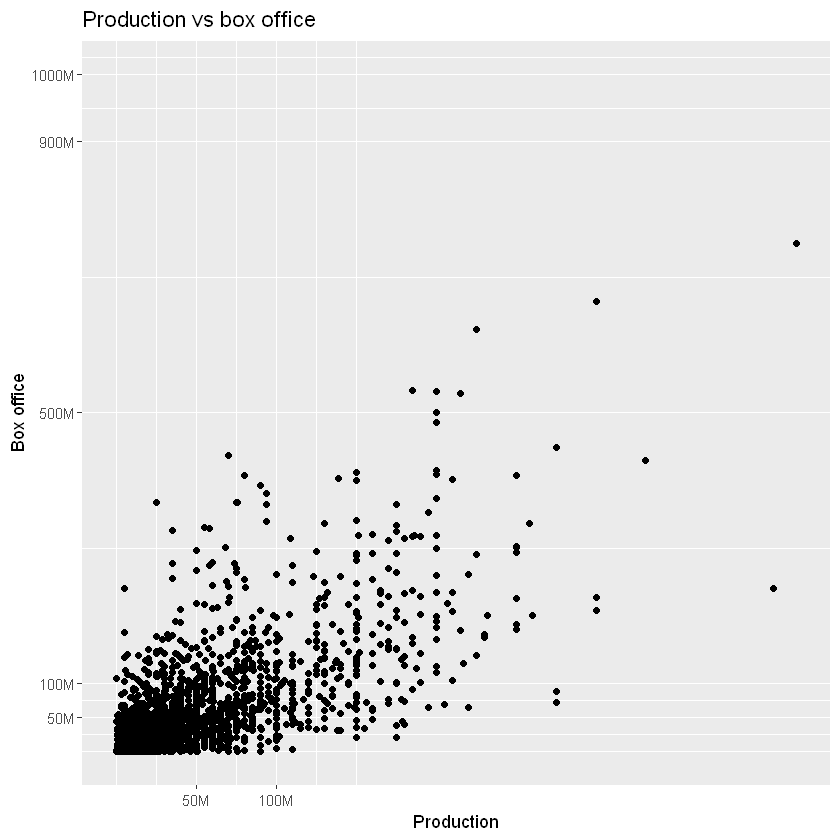

In [41]:
#Run the graph
theNumbersgraph

In [ ]:
#what this graph shows is in general the more production budget spent 
#on a movie, the higher likelyhood that it is going to have a higher revenue at the box office
#this is not always true